In [ ]:
!pip install replay-rec --quiet
!pip install implicit
!pip install catboost
!pip install rs_datasets

In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import CosineRecommender
from replay.metrics import NDCG, Coverage, Experiment, HitRate, Recall
from replay.preprocessing.filters import MinCountFilter
from replay.splitters import TimeSplitter
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

## Подготовка данных

Загружаем датасет Movielens-1m.

In [ ]:
from rs_datasets import MovieLens

data = MovieLens("1m")
ratings, items, users = data.ratings, data.items, data.users
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Смотрим на статистики и фильтруем пользователей и айтемы с малым количеством взаимодействий.

In [ ]:
print('До фильтрации')
print(f"Количество взаимодействий: {len(ratings)}")
print(f"Уникальных пользователей: {ratings['user_id'].nunique()}")
print(f"Уникальных айтемов: {ratings['item_id'].nunique()}")

ratings = MinCountFilter(5, groupby_column='user_id').transform(ratings)
ratings = MinCountFilter(5, groupby_column='item_id').transform(ratings)

print('После фильтрации')
print(f"Количество взаимодействий: {len(ratings)}")
print(f"Уникальных пользователей: {ratings['user_id'].nunique()}")
print(f"Уникальных айтемов: {ratings['item_id'].nunique()}")

До фильтрации
Количество взаимодействий: 1000209
Уникальных пользователей: 6040
Уникальных айтемов: 3706
После фильтрации
Количество взаимодействий: 999611
Уникальных пользователей: 6040
Уникальных айтемов: 3416


Подготавливаем таблицу с признаками айтемов.

In [ ]:
items['year'] = items['title'].str.split('(').apply(lambda x: int(x[-1][:-1]))
items = items.join(items['genres'].str.get_dummies())
items = items.drop(columns=['title', 'genres'])
print(items.shape)
items.head()

(3883, 20)


,item_id,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Удаляем малоинформативный признак zip_code из таблицы с признаками пользователей.

In [ ]:
users = users.drop('zip_code', axis=1)

## Разбиение данных

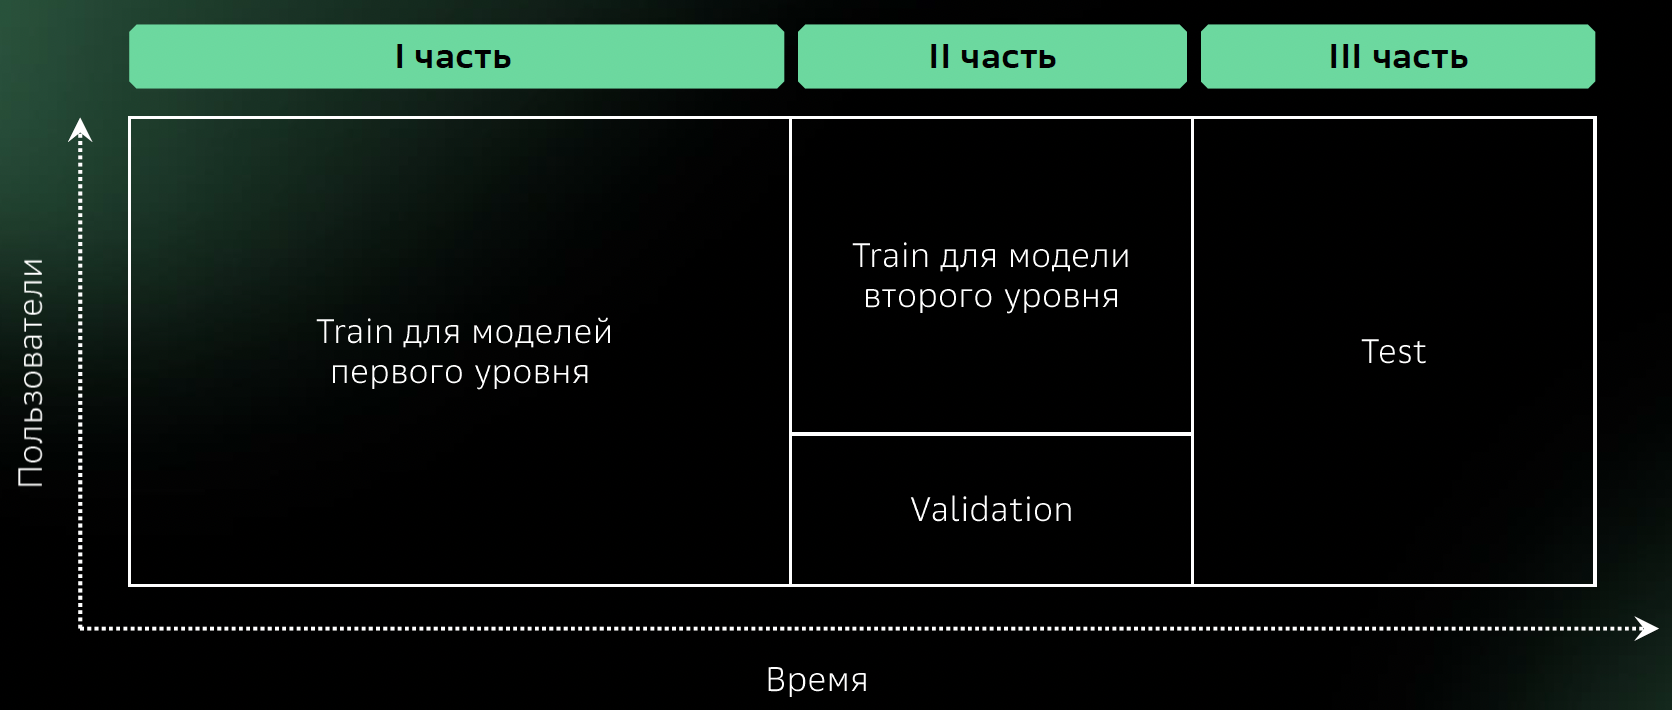

Разбиваем по времени, удаляем холодных пользователей и холодные айтемы.

Сперва отделяем тест, на котором будем проверять итоговое качество получившейся модели.

In [ ]:
splitter = TimeSplitter(time_threshold=0.05, query_column='user_id',
                        item_column='item_id', timestamp_column='timestamp',
                        drop_cold_users=True, drop_cold_items=True)
train, test = splitter.split(ratings)

print(f'Количество взаимодействий в train (I+II часть) {train.shape[0]}')
print(f'Количество взаимодействий в test (III часть) {test.shape[0]}')
print(f'Количество пользователей в train (I+II часть) {train.user_id.nunique()}')
print(f'Количество пользователей в test (III часть) {test.user_id.nunique()}')

Количество взаимодействий в train (I+II часть) 949630
Количество взаимодействий в test (III часть) 49091
Количество пользователей в train (I+II часть) 6036
Количество пользователей в test (III часть) 809


Затем разделяем на часть для обучения моделей первого уровня и на часть для обучения второго уровня.

In [ ]:
splitter = TimeSplitter(time_threshold=0.2, query_column='user_id',
                        item_column='item_id', timestamp_column='timestamp',
                        drop_cold_users=True, drop_cold_items=True)
train_first_stage, data_second_stage = splitter.split(train)

print(f'Количество взаимодействий в I части {train_first_stage.shape[0]}')
print(f'Количество взаимодействий во II части {data_second_stage.shape[0]}')
print(f'Количество пользователей в I части {train_first_stage.user_id.nunique()}')
print(f'Количество пользователей во II части {data_second_stage.user_id.nunique()}')

Количество взаимодействий в I части 759702
Количество взаимодействий во II части 66357
Количество пользователей в I части 5185
Количество пользователей во II части 959


## Модели первого уровня

В качестве моделей первого уровня будем использовать ALS и KNN из библиотеки implicit.

Сперва подготавливаем разреженную матрицу, которую нужно подать на вход модели для обучения.

In [ ]:
train_first_stage_csr = csr_matrix((np.ones(len(train_first_stage)),
                                   (train_first_stage["user_id"], train_first_stage["item_id"])))
train_first_stage_csr

<6041x3953 sparse matrix of type '<class 'numpy.float64'>'
	with 759702 stored elements in Compressed Sparse Row format>

Обучаем ALS.

In [ ]:
ALS_FACTORS = 20
ALS_ITERATIONS = 10

als_model = AlternatingLeastSquares(factors=ALS_FACTORS, iterations=ALS_ITERATIONS)
als_model.fit(train_first_stage_csr)

  0%|          | 0/10 [00:00<?, ?it/s]

Выполняем генерацию кандидатов. Задаем количество кандидатов, которых берем от каждой модели.

In [ ]:
NUM_CANDIDATES = 100

user_ids = data_second_stage['user_id'].unique()
item_ids, scores = als_model.recommend(
    userid=user_ids,
    user_items=train_first_stage_csr[user_ids],
    N=NUM_CANDIDATES,
    filter_already_liked_items=True)

Собираем предсказания в датафрейм стандартного формата.

In [ ]:
als_candidates = pd.DataFrame({'user_id': user_ids, 'item_id': list(item_ids),
                               'score': list(scores)})
als_candidates = als_candidates.explode(['item_id', 'score'])
print(als_candidates.shape)
als_candidates.head()

(95900, 3)


,user_id,item_id,score
0,850,111,0.696676
0,850,924,0.641917
0,850,1248,0.548303
0,850,1284,0.538862
0,850,541,0.537332


Обучаем и делаем предсказания с помощью KNN.

In [ ]:
NUM_NEIGHBOURS = 30

knn_model = CosineRecommender(K=NUM_NEIGHBOURS)
knn_model.fit(train_first_stage_csr)

item_ids, scores = knn_model.recommend(
    userid=user_ids,
    user_items=train_first_stage_csr[user_ids],
    N=NUM_CANDIDATES,
    filter_already_liked_items=True)

knn_candidates = pd.DataFrame({'user_id': user_ids, 'item_id': list(item_ids),
                               'score': list(scores)})
knn_candidates = knn_candidates.explode(['item_id', 'score'])
print(knn_candidates.shape)
knn_candidates.head()

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006674766540527344 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

(95900, 3)


,user_id,item_id,score
0,850,1196,12.925814
0,850,924,12.122863
0,850,111,12.032642
0,850,260,11.971397
0,850,1208,11.901365


Посмотрим метрики обученных моделей на данных части II.

In [ ]:
%%time

metrics = Experiment(
    [NDCG(10), HitRate(10), Coverage(10), Recall(100)],
    ground_truth=data_second_stage[['user_id', 'item_id']],
    train=train_first_stage,
    query_column="user_id", item_column="item_id", rating_column="score")

metrics.add_result("ALS", als_candidates)
metrics.add_result("KNN", knn_candidates)
metrics.results

/usr/local/lib/python3.10/dist-packages/replay/metrics/base_metric.py:80: MetricDuplicatesWarning: The recommendations contain duplicated users and items.The metrics may be higher than the actual ones.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/replay/metrics/base_metric.py:80: MetricDuplicatesWarning: The recommendations contain duplicated users and items.The metrics may be higher than the actual ones.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/replay/metrics/base_metric.py:80: MetricDuplicatesWarning: The recommendations contain duplicated users and items.The metrics may be higher than the actual ones.
  warnings.warn(


CPU times: user 2.06 s, sys: 51 ms, total: 2.11 s
Wall time: 2.11 s


/usr/local/lib/python3.10/dist-packages/replay/metrics/base_metric.py:80: MetricDuplicatesWarning: The recommendations contain duplicated users and items.The metrics may be higher than the actual ones.
  warnings.warn(


,NDCG@10,HitRate@10,Coverage@10,Recall@100
ALS,0.19217,0.583942,0.194371,0.238015
KNN,0.19900,0.544317,0.109645,0.198274


Объединяем кандидатов от разных моделей в один датафрейм.

In [ ]:
candidates = pd.merge(als_candidates, knn_candidates, on=['user_id', 'item_id'], how='outer')
candidates.columns = ['user_id', 'item_id', 'score1', 'score2']
print(candidates.shape)
candidates.head()

(138821, 4)


<ipython-input-31-4f82294fbbfc>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  candidates = pd.merge(als_candidates, knn_candidates, on=['user_id', 'item_id'], how='outer')


,user_id,item_id,score1,score2
0,850,111.0,0.696676,12.032642
1,850,924.0,0.641917,12.122863
2,850,1248.0,0.548303,6.077977
3,850,1284.0,0.538862,3.988065
4,850,541.0,0.537332,7.397763


## Модель второго уровня

### Определение таргета

Проставляем таргет 1 у тех пар (пользователь, айтем), которые встречались в данных для обучения модели второго уровня. У остальных кандидатов таргет 0.

In [ ]:
positives = pd.merge(candidates[['user_id', 'item_id']], data_second_stage[['user_id', 'item_id']])
positives['target'] = 1
print(len(positives))

candidates = pd.merge(candidates, positives, how='left')
candidates.target.fillna(0, inplace=True)
print(candidates.shape)
candidates.head()

15344
(138821, 5)


,user_id,item_id,score1,score2,target
0,850,111.0,0.696676,12.032642,0.0
1,850,924.0,0.641917,12.122863,0.0
2,850,1248.0,0.548303,6.077977,0.0
3,850,1284.0,0.538862,3.988065,0.0
4,850,541.0,0.537332,7.397763,0.0


### Добавление признаков

Добавляем признаки пользователей и айтемов.

In [ ]:
data = pd.merge(candidates, users)
data = pd.merge(data, items)
print(data.shape)
data.head()

(138726, 27)


,user_id,item_id,score1,score2,target,gender,age,occupation,year,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,850,111.0,0.696676,12.032642,0.0,M,35,0,1976,0,...,0,0,0,0,0,0,0,1,0,0
1,1484,111,NaN,2.573568,0.0,M,25,12,1976,0,...,0,0,0,0,0,0,0,1,0,0
2,1943,111.0,0.71529,6.591514,0.0,M,18,4,1976,0,...,0,0,0,0,0,0,0,1,0,0
3,1540,111.0,0.291529,4.152307,0.0,M,45,0,1976,0,...,0,0,0,0,0,0,0,1,0,0
4,2047,111.0,0.513275,NaN,0.0,M,1,10,1976,0,...,0,0,0,0,0,0,0,1,0,0


Добавим статистики для айтемов на основе истории взаимодействий - общую популярность айтемов, популярность в разрезе пола и возраста.

In [ ]:
train_first_stage = pd.merge(train_first_stage, users)

item_count = train_first_stage.groupby('item_id').size().rename('item_count').reset_index()
item_gender_count = train_first_stage.groupby(['item_id', 'gender']).size().rename('item_gender_count').reset_index()
item_age_count = train_first_stage.groupby(['item_id', 'age']).size().rename('item_age_count').reset_index()

In [ ]:
data = pd.merge(data, item_count, how='left')
data = pd.merge(data, item_gender_count, how='left')
data = pd.merge(data, item_age_count, how='left')
print(data.shape)
data.head()

(138726, 30)


,user_id,item_id,score1,score2,target,gender,age,occupation,year,Action,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,item_count,item_gender_count,item_age_count
0,850,111.0,0.696676,12.032642,0.0,M,35,0,1976,0,...,0,0,0,0,1,0,0,1005,808.0,219.0
1,1484,111,NaN,2.573568,0.0,M,25,12,1976,0,...,0,0,0,0,1,0,0,1005,808.0,396.0
2,1943,111.0,0.71529,6.591514,0.0,M,18,4,1976,0,...,0,0,0,0,1,0,0,1005,808.0,147.0
3,1540,111.0,0.291529,4.152307,0.0,M,45,0,1976,0,...,0,0,0,0,1,0,0,1005,808.0,96.0
4,2047,111.0,0.513275,NaN,0.0,M,1,10,1976,0,...,0,0,0,0,1,0,0,1005,808.0,13.0


### Разбиение данных для модели второго уровня

Делаем сплит по пользователям.

In [ ]:
users_train, users_validation = train_test_split(
    data['user_id'].unique(), test_size=0.1, random_state=42)
print(len(users_train), len(users_validation))

train_second_stage = data[data.user_id.isin(users_train)]
validation_second_stage = data[data.user_id.isin(users_validation)]

print(train_second_stage.shape)
print(validation_second_stage.shape)

863 96
(125085, 30)
(13641, 30)


### Обучение

Готовим финальные данные для обучения бустинга.

In [ ]:
cols_to_drop = ['user_id', 'item_id']
cat_features = ['gender']

ytrain = train_second_stage['target']
Xtrain = train_second_stage.drop(cols_to_drop + ['target'], axis=1)

yval = validation_second_stage['target']
Xval = validation_second_stage.drop(cols_to_drop + ['target'], axis=1)

print(Xtrain.shape, ytrain.shape)
print(Xval.shape, yval.shape)

(125085, 27) (125085,)
(13641, 27) (13641,)


Обучаем модель.

In [ ]:
CATBOOST_PARAMS = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 5,
    'random_seed': 42
}

catboost_model = CatBoostClassifier(**CATBOOST_PARAMS)

catboost_model.fit(Xtrain, ytrain,
                   eval_set=(Xval, yval),
                   cat_features=cat_features,
                   early_stopping_rounds=100,
                   verbose=50)

0:	learn: 0.6848518	test: 0.6850952	best: 0.6850952 (0)	total: 79ms	remaining: 1m 18s
50:	learn: 0.4450165	test: 0.4556578	best: 0.4556578 (50)	total: 1.39s	remaining: 25.8s
100:	learn: 0.3716858	test: 0.3884604	best: 0.3884604 (100)	total: 2.73s	remaining: 24.3s
150:	learn: 0.3474776	test: 0.3683186	best: 0.3683186 (150)	total: 4.05s	remaining: 22.8s
200:	learn: 0.3383016	test: 0.3619074	best: 0.3619074 (200)	total: 7.05s	remaining: 28s
250:	learn: 0.3344116	test: 0.3597538	best: 0.3597538 (250)	total: 8.63s	remaining: 25.8s
300:	learn: 0.3323102	test: 0.3587642	best: 0.3587642 (300)	total: 9.96s	remaining: 23.1s
350:	learn: 0.3310490	test: 0.3581840	best: 0.3581835 (349)	total: 11.3s	remaining: 20.9s
400:	learn: 0.3299664	test: 0.3574480	best: 0.3574480 (400)	total: 12.6s	remaining: 18.9s
450:	learn: 0.3290291	test: 0.3571932	best: 0.3571925 (448)	total: 13.9s	remaining: 17s
500:	learn: 0.3282319	test: 0.3569388	best: 0.3569388 (500)	total: 15.3s	remaining: 15.2s
550:	learn: 0.327472

Посмотрим на метрику на валидационной части - проверим, что модель чему-то обучилась.

In [ ]:
roc_auc_score(yval, catboost_model.predict_proba(Xval)[:, 1])

0.6632655895511735

## Предсказание на тесте

Для предсказания на тесте переобучим модели первого уровня с учетом свежих данных - на объединенных данных I и II части.

In [ ]:
train_csr = csr_matrix((np.ones(len(train)), (train["user_id"], train["item_id"])))
user_ids = test['user_id'].unique()

Запускаем ALS.

In [ ]:
als_model = AlternatingLeastSquares(factors=ALS_FACTORS, iterations=ALS_ITERATIONS)
als_model.fit(train_csr)

item_ids, scores = als_model.recommend(
    userid=user_ids,
    user_items=train_csr[user_ids],
    N=NUM_CANDIDATES,
    filter_already_liked_items=True)

als_candidates_test = pd.DataFrame({'user_id': user_ids, 'item_id': list(item_ids),
                                    'score': list(scores)})
als_candidates_test = als_candidates_test.explode(['item_id', 'score'])
print(als_candidates_test.shape)
als_candidates_test.head()

  0%|          | 0/10 [00:00<?, ?it/s]

(80900, 3)


,user_id,item_id,score
0,3125,2028,0.632134
0,3125,593,0.610653
0,3125,2716,0.564844
0,3125,2959,0.558198
0,3125,1210,0.505147


Запускаем KNN.

In [ ]:
knn_model = CosineRecommender(K=NUM_NEIGHBOURS)
knn_model.fit(train_csr)

item_ids, scores = knn_model.recommend(
    userid=user_ids,
    user_items=train_csr[user_ids],
    N=NUM_CANDIDATES,
    filter_already_liked_items=True)

knn_candidates_test = pd.DataFrame({'user_id': user_ids, 'item_id': list(item_ids),
                                    'score': list(scores)})
knn_candidates_test = knn_candidates_test.explode(['item_id', 'score'])
print(knn_candidates_test.shape)
knn_candidates_test.head()

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007729291915893555 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

(80900, 3)


,user_id,item_id,score
0,3125,1198,15.049687
0,3125,2028,14.565373
0,3125,2716,13.66593
0,3125,480,13.430821
0,3125,593,12.454026


Объединяем предсказания от разных моделей.

In [ ]:
candidates_test = pd.merge(als_candidates_test, knn_candidates_test, on=['user_id', 'item_id'], how='outer')
candidates_test.columns = ['user_id', 'item_id', 'score1', 'score2']
print(candidates_test.shape)
candidates_test.head()

(116347, 4)


<ipython-input-43-7cff6933a3ec>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  candidates_test = pd.merge(als_candidates_test, knn_candidates_test, on=['user_id', 'item_id'], how='outer')


,user_id,item_id,score1,score2
0,3125,2028.0,0.632134,14.565373
1,3125,593.0,0.610653,12.454026
2,3125,2716.0,0.564844,13.66593
3,3125,2959.0,0.558198,8.242214
4,3125,1210.0,0.505147,11.092575


Добавляем те же признаки, которые использовались при обучении.

In [ ]:
test_data = pd.merge(candidates_test, users)
test_data = pd.merge(test_data, items)
test_data = pd.merge(test_data, item_count, how='left')
test_data = pd.merge(test_data, item_gender_count, how='left')
test_data = pd.merge(test_data, item_age_count, how='left')
print(test_data.shape)
test_data.head()

(116282, 29)


,user_id,item_id,score1,score2,gender,age,occupation,year,Action,Adventure,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,item_count,item_gender_count,item_age_count
0,3125,2028.0,0.632134,14.565373,M,25,7,1998,1,0,...,0,0,0,0,0,1,0,2146,1676,840.0
1,3158,2028.0,0.758816,19.804518,M,25,15,1998,1,0,...,0,0,0,0,0,1,0,2146,1676,840.0
2,752,2028.0,0.691425,26.049238,F,25,3,1998,1,0,...,0,0,0,0,0,1,0,2146,470,840.0
3,4682,2028.0,0.787793,30.921354,M,25,7,1998,1,0,...,0,0,0,0,0,1,0,2146,1676,840.0
4,846,2028.0,0.613744,15.30846,M,25,5,1998,1,0,...,0,0,0,0,0,1,0,2146,1676,840.0


Делаем предсказания моделью второго уровня.

In [ ]:
Xtest = test_data.drop(cols_to_drop, axis=1)

predictions = test_data[['user_id', 'item_id']]
predictions['score'] = catboost_model.predict_proba(Xtest)[:, 1]
predictions = predictions.sort_values(by=['user_id', 'score'], ascending=False).reset_index(drop=True)
predictions.head()

<ipython-input-45-04678b3408b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['score'] = catboost_model.predict_proba(Xtest)[:, 1]


,user_id,item_id,score
0,6040,3481.0,0.314149
1,6040,1221.0,0.224823
2,6040,2571.0,0.221439
3,6040,1270.0,0.219916
4,6040,480,0.193716


Посмотрим на получившиеся метрики на тестовых данных.

In [ ]:
%%time

K = [10]
metrics = Experiment(
    [NDCG(K), HitRate(K), Coverage(K)],
    ground_truth=test[['user_id', 'item_id']],
    train=train,
    query_column="user_id", item_column="item_id", rating_column="score")

metrics.add_result("ALS", als_candidates_test[['user_id', 'item_id', 'score']])
metrics.add_result("KNN", knn_candidates_test[['user_id', 'item_id', 'score']])
metrics.add_result("CatBoost", predictions)
metrics.results

/usr/local/lib/python3.10/dist-packages/replay/metrics/base_metric.py:80: MetricDuplicatesWarning: The recommendations contain duplicated users and items.The metrics may be higher than the actual ones.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/replay/metrics/base_metric.py:80: MetricDuplicatesWarning: The recommendations contain duplicated users and items.The metrics may be higher than the actual ones.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/replay/metrics/base_metric.py:80: MetricDuplicatesWarning: The recommendations contain duplicated users and items.The metrics may be higher than the actual ones.
  warnings.warn(


CPU times: user 2.65 s, sys: 105 ms, total: 2.76 s
Wall time: 2.82 s


,NDCG@10,HitRate@10,Coverage@10
ALS,0.239213,0.657602,0.195550
KNN,0.222080,0.646477,0.094555
CatBoost,0.244967,0.723115,0.098946
